In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer # converts text to numerical features (TF-IDF)
from sklearn.cluster import KMeans # clusters numerical representations (tries to distribute as even size as possible)
from sentence_transformers import SentenceTransformer # converts sentences into dense embeddings
from umap import UMAP # reduces dimensionality of embeddings bc clustering algorithms struggle with large data
from bertopic import BERTopic # topic modeling using Transformer-based embeddings
import hdbscan # identify natural clusters without forcing every product to be one, else labeled as noise (doesn't have to be same size)
import re # regular expressions for text preprocessing

/Users/songchen/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/songchen/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class ProductGroupGenerator:
    def __init__(self, min_cluster_size = 5, max_clusters = 75):
        self.sentence_model = SentenceTransformer('all-MiniLM-L6-v2')
        self.tfidf = TfidfVectorizer(
            max_features = 1000,
            stop_words='english',
            ngram_range=(1, 2)
        )
        self.min_cluster_size = min_cluster_size
        self.max_clusters = max_clusters
        
    def preprocess_text(self, text):
        # convert to lowercase and remove special characters
        text = re.sub(r'[^a-zA-Z0-9\s]', ' ', str(text).lower())
        # remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()
        return text
        
    def generate_clusters(self, texts, method = 'combined', n_clusters = None):
        """
        Generate product clusters using different methods
        
        Args:
            texts: List of product titles/descriptions
            method: One of 'tfidf_kmeans', 'bert_topic', or 'combined'
            n_clusters: Optional target number of clusters
        """
        if n_clusters is None:
            n_clusters = min(len(texts) // self.min_cluster_size, self.max_clusters)
            
        processed_texts = [self.preprocess_text(text) for text in texts]
        
        if method == 'tfidf_kmeans':
            return self._cluster_tfidf_kmeans(processed_texts, n_clusters)
        elif method == 'bert_topic':
            return self._cluster_bert_topic(processed_texts)
        elif method == 'combined':
            return self._cluster_combined(processed_texts, n_clusters)
        else:
            raise ValueError("Invalid clustering method")
    
    def _cluster_tfidf_kmeans(self, texts, n_clusters):
        # transform texts to TF-IDF vectors
        tfidf_matrix = self.tfidf.fit_transform(texts)
        
        kmeans = KMeans(n_clusters = n_clusters, random_state = 42)
        labels = kmeans.fit_predict(tfidf_matrix)
        
        # get top terms for each cluster
        cluster_terms = {}
        feature_names = self.tfidf.get_feature_names_out()
        for i in range(n_clusters):
            center_indices = kmeans.cluster_centers_[i].argsort()[::-1][:5]
            cluster_terms[i] = [feature_names[idx] for idx in center_indices]
            
        return labels, cluster_terms
    
    def _cluster_bert_topic(self, texts):
        # create embeddings
        embeddings = self.sentence_model.encode(texts)
        
        # initialize BERTopic
        topic_model = BERTopic(
            umap_model = UMAP(n_neighbors = 15, n_components = 5, min_dist = 0.0, metric = 'cosine'),
            hdbscan_model = hdbscan.HDBSCAN(
                min_cluster_size = self.min_cluster_size,
                min_samples = 1,
                metric = 'euclidean',
                cluster_selection_method = 'eom'
            ),
            verbose=True
        )
        
        # fit the model and get topics
        labels, _ = topic_model.fit_transform(texts, embeddings)
        
        # get topic terms
        topic_terms = {}
        for topic_idx, words in topic_model.get_topics().items():
            topic_terms[topic_idx] = [word[0] for word in words[:5]]
            
        return labels, topic_terms
    
    def _cluster_combined(self, texts, n_clusters):
        # get clusters from both methods
        print("CLUSTERING BY KMEANS")
        kmeans_labels, kmeans_terms = self._cluster_tfidf_kmeans(texts, n_clusters)
        print("CLUSTERING BY BERT")
        bert_labels, bert_terms = self._cluster_bert_topic(texts)
        
        # create ensemble clustering
        # convert labels to one-hot encoding
        def one_hot_encode(labels):
            n_unique = len(np.unique(labels))
            return np.eye(n_unique)[labels]
        
        kmeans_oh = one_hot_encode(kmeans_labels)
        bert_oh = one_hot_encode(bert_labels)
        
        # concatenate features
        combined_features = np.hstack([kmeans_oh, bert_oh])
        
        # final clustering on combined features
        print("CREATING FINAL CLUSTERING COMBINATION")
        final_kmeans = KMeans(n_clusters=n_clusters)
        final_labels = final_kmeans.fit_predict(combined_features)
        
        # combine terms from both methods for final clusters
        final_terms = {}
        for i in range(n_clusters):
            terms_set = set()
            terms_set.update(kmeans_terms.get(i, []))
            terms_set.update(bert_terms.get(i, []))
            final_terms[i] = list(terms_set)[:5]
            
        return final_labels, final_terms

    def analyze_clusters(self, texts, labels, cluster_terms):
        """
        Analyze cluster quality and characteristics
        """
        cluster_stats = {}
        unique_labels = np.unique(labels)
        
        for label in unique_labels:
            cluster_texts = [texts[i] for i in range(len(texts)) if labels[i] == label]
            cluster_stats[label] = {
                'size': len(cluster_texts),
                'terms': cluster_terms.get(label, []),
                'sample_products': cluster_texts[:3]  # Show 3 example products
            }
            
        return cluster_stats

In [3]:
# prepare your data
products_df = pd.read_csv("cds_vinyl_product.csv")
texts = products_df['title'] + ' ' + products_df['description']

In [4]:
# initialize clustering class
generator = ProductGroupGenerator(min_cluster_size = 50, max_clusters = 200)

In [5]:
# run clustering
labels, cluster_terms = generator.generate_clusters(texts, method = 'combined')

CLUSTERING BY KMEANS
CLUSTERING BY BERT


2025-02-27 20:40:32,903 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
2025-02-27 20:40:43,350 - BERTopic - Dimensionality - Completed ✓
2025-02-27 20:40:43,351 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-02-27 20:40:43,411 - BERTopic - Cluster - Completed ✓
2025-02-27 20:40:43,415 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-02-27 20:40:43,623 - BERTopic - Representation - Completed ✓


CREATING FINAL CLUSTERING COMBINATION


In [6]:
# analyze the clusters
cluster_stats = generator.analyze_clusters(texts, labels, cluster_terms)

In [7]:
# number of total products
products_df.shape[0] 

3502

In [8]:
# number of clusters
len(cluster_stats)

70

In [9]:
# sample of group sizes and key terms
for i in range(10):
    print(f"Cluster Size: {cluster_stats[i]['size']}")
    print(f"Key Terms: {', '.join(cluster_stats[i]['terms'])}\n")

Cluster Size: 36
Key Terms: the, her, brian, in, stereo

Cluster Size: 40
Key Terms: 180 gram, gram vinyl, to, the, vinyl

Cluster Size: 28
Key Terms: antiskate, the, beatles, player, in

Cluster Size: 82
Key Terms: gilmour, floyd, the, pink floyd, in

Cluster Size: 4
Key Terms: to, the, black, his, of

Cluster Size: 90
Key Terms: certified, floyd, the, released, hits

Cluster Size: 102
Key Terms: digitally, the, digitally remastered, live, blue

Cluster Size: 1
Key Terms: companion, the, in, original, companion audio

Cluster Size: 59
Key Terms: antiskate, adjust, song, try, album

Cluster Size: 77
Key Terms: the, release, lyrics, holiday, album



In [10]:
# extract the size of each cluster and store it in the list
num_items = []

for cluster in cluster_stats.keys():
    num_items.append(cluster_stats[cluster]['size'])

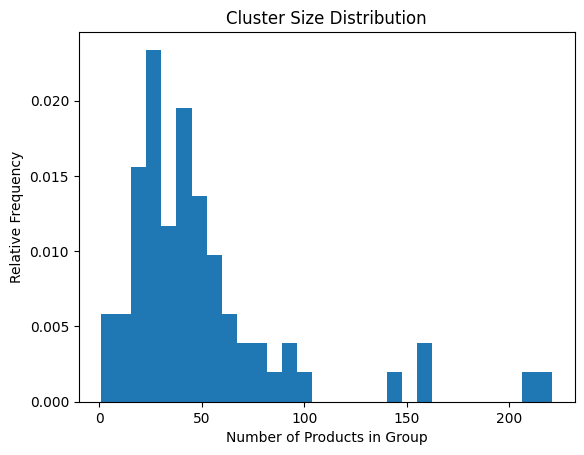

In [11]:
plt.hist(num_items, bins = 30, density = True)
plt.title("Cluster Size Distribution")
plt.xlabel("Number of Products in Group")
plt.ylabel("Relative Frequency")
plt.show()

In [12]:
products_df['label'] = labels # add a new column label where each row gets assigned a cluster number
products_df['label'].value_counts()[:5] # counts the number of products in each cluster and sort in descending order

label
23    221
60    212
52    162
47    156
30    145
Name: count, dtype: int64

In [14]:
cluster_stats[23]

{'size': 221,
 'terms': ['albums', 'stones', 'album', 'rolling stones', 'rolling'],
 'sample_products': ['Thanks for the Dance 2019 posthumous release from the late singersongwriter produced by leonards son adam and engineered and mixed by michael chaves the duo also worked together with leonard on the 2016 album you want it darker thanks for the dance is not a commemorative collection of b sides and outtakes but an unexpected harvest of new songs exciting and vital a continuation of the masters final work this remarkable album was made in many places javier mas the great spanish laud player who accompanied leonard on stage for the last eight years of touring flew from barcelona to los angeles to capture the artists spirit on leonards own guitar in berlin at a musical event called people festival adam invited friends and comrades to lend their ears and talents damien rice and leslie feist sang richard reed parry of arcade fire played bass bryce dessner of the national played guitar the

In [16]:
products_df.to_csv("labeled_cds_vinyl_products.csv", index = False)